In [1]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from deep_generalizability.nets import Nets
from deep_generalizability.utils import *
from deep_generalizability.postprocessing.postprocessing import *
from deep_generalizability.postprocessing.stats_plotting import *
from deep_generalizability.save_load import *

from deep_generalizability.postprocessing.sharpness_measures import *
from deep_generalizability.postprocessing.stats_plotting import *

from deep_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


In [13]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "MNIST"
exp = "Aug31_14-34-37_Daniels-MacBook-Pro-4.local"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [14]:
stats_df = get_end_stats(experiment_folder)


In [15]:
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Gap Mean,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Loss Test Max,Loss Test Mean,Loss Test Min,Loss Train Max,Loss Train Mean,Loss Train Min,Norm Max,Norm Mean,Norm Min,batch_train_size,learning_rate
1598877418.373299,-0.0056,0.9408,0.9408,0.9408,0.9464,0.9464,0.9464,0.212352,0.212352,0.212352,0.195829,0.195829,0.195829,14.305261,14.305261,14.305261,128,0.1
1598877308.899329,0.0022,0.9264,0.9264,0.9264,0.9242,0.9242,0.9242,0.268383,0.268383,0.268383,0.263523,0.263523,0.263523,13.994125,13.994125,13.994125,128,0.01
1598877411.737395,0.0036,0.9224,0.9224,0.9224,0.9188,0.9188,0.9188,0.279712,0.279712,0.279712,0.281766,0.281766,0.281766,14.077614,14.077614,14.077614,64,0.1
1598877307.7362921,-0.0026,0.9114,0.9114,0.9114,0.9140,0.9140,0.9140,0.315046,0.315046,0.315046,0.315515,0.315515,0.315515,13.868262,13.868262,13.868262,64,0.01
1598877304.382367,-0.0008,0.9106,0.9106,0.9106,0.9114,0.9114,0.9114,0.322952,0.322952,0.322952,0.329251,0.329251,0.329251,13.834139,13.834139,13.834139,128,0.001
1598877303.249424,-0.0008,0.9106,0.9106,0.9106,0.9114,0.9114,0.9114,0.324098,0.324098,0.324098,0.329467,0.329467,0.329467,13.834057,13.834057,13.834057,64,0.001
1598877387.8192909,0.0062,0.9060,0.9060,0.9060,0.8998,0.8998,0.8998,0.308475,0.308475,0.308475,0.315925,0.315925,0.315925,14.153720,14.153720,14.153720,32,0.1
1598877305.6744,0.0002,0.9030,0.9030,0.9030,0.9028,0.9028,0.9028,0.355276,0.355276,0.355276,0.363824,0.363824,0.363824,13.801430,13.801430,13.801430,16,0.01
1598877302.1398358,0.0012,0.9002,0.9002,0.9002,0.8990,0.8990,0.8990,0.375745,0.375745,0.375745,0.387116,0.387116,0.387116,13.739265,13.739265,13.739265,32,0.001
1598877306.696288,0.0030,0.8970,0.8970,0.8970,0.8940,0.8940,0.8940,0.380571,0.380571,0.380571,0.395916,0.395916,0.395916,13.735177,13.735177,13.735177,32,0.01


In [5]:
point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=-1)

In [9]:
margin_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=-1, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)


In [10]:
linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=-1, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)


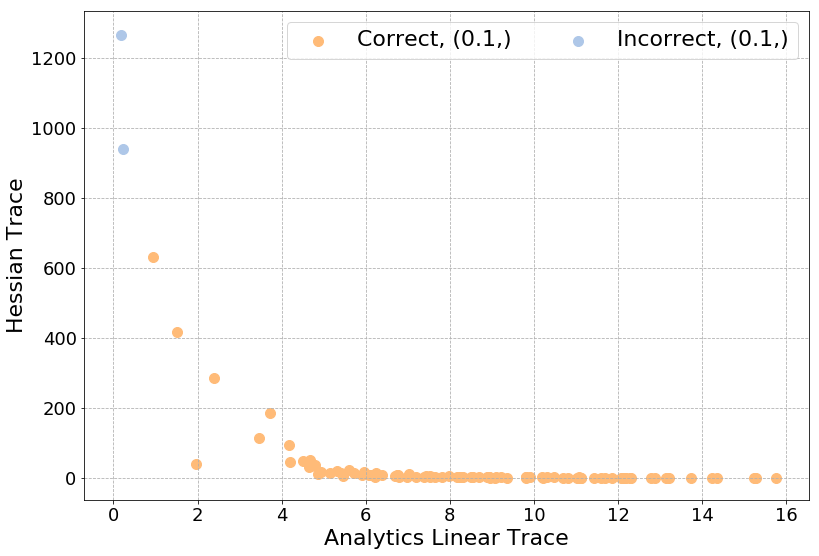

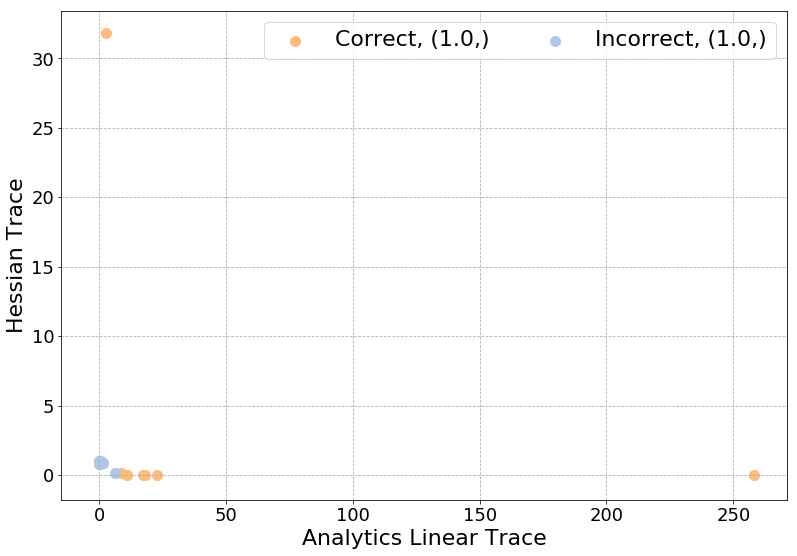

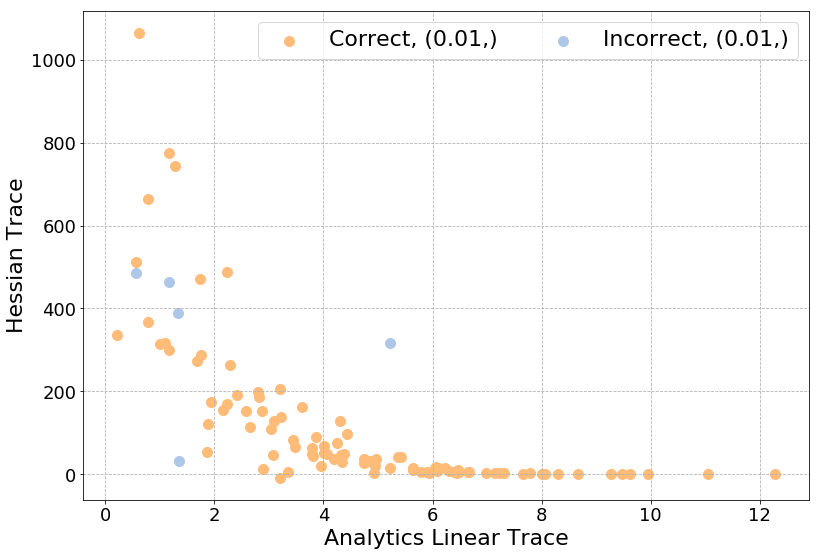

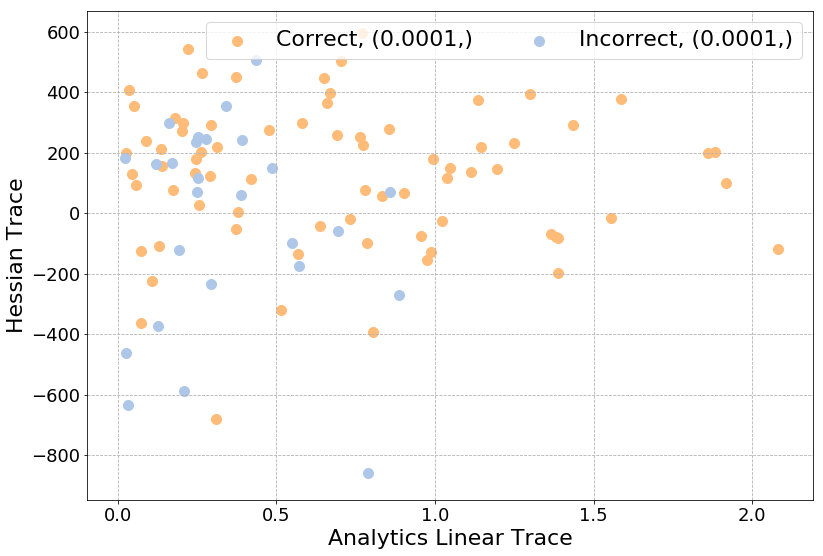

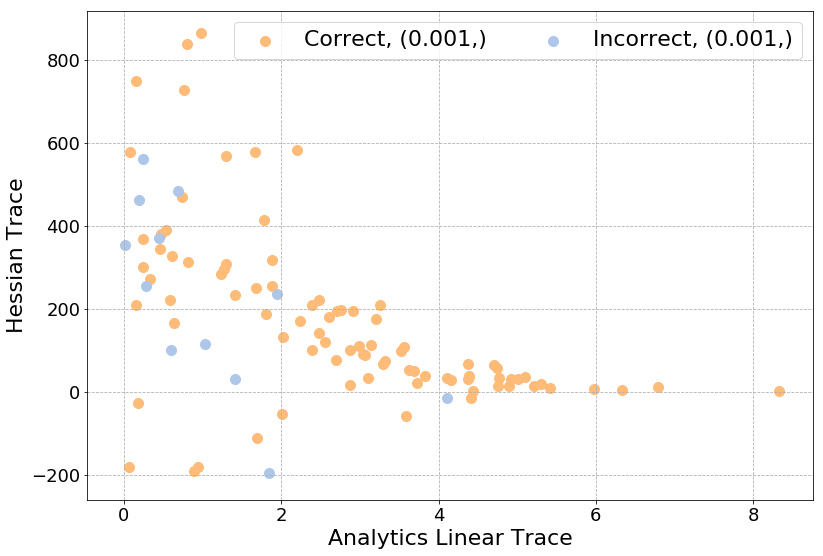

In [11]:

# Plot trace vs margins
X_axis_name = "Analytics Linear Trace"
Y_axis_name = "Hessian Trace"


plot_name = "Correct_Incorrect"
X_axis_bounds = None
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = ["learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True

data_func = margin_trace_correct_incorrect_plot(margin_filters, point_traces, use_correct_filter=use_correct_filter)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)



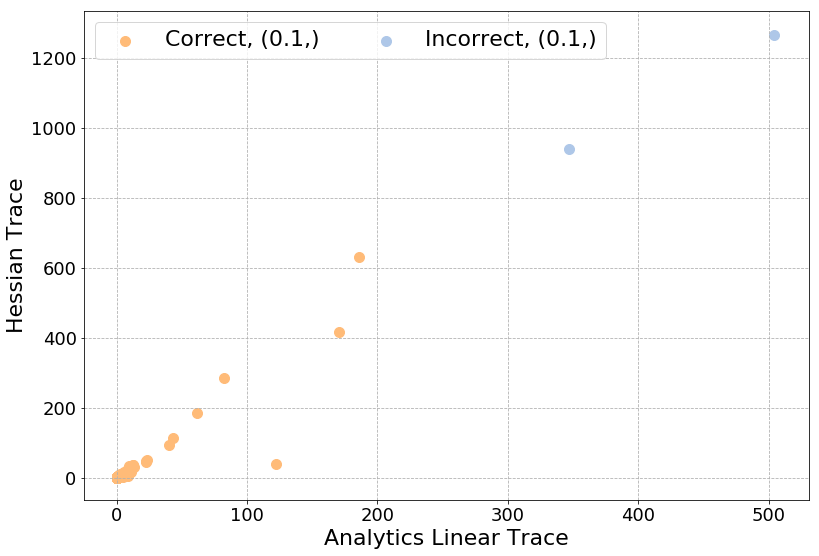

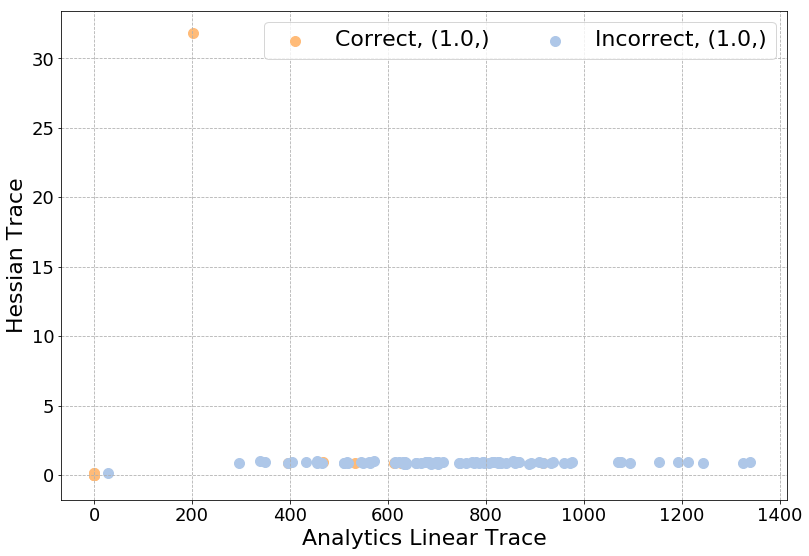

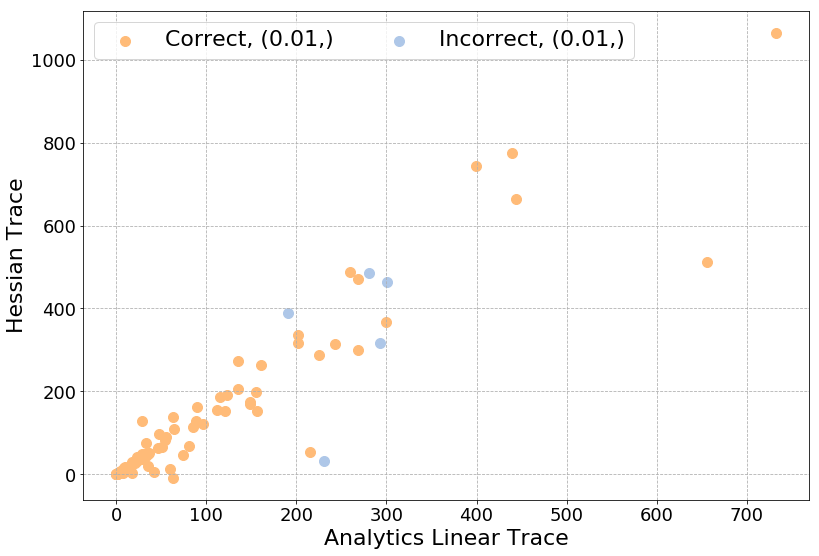

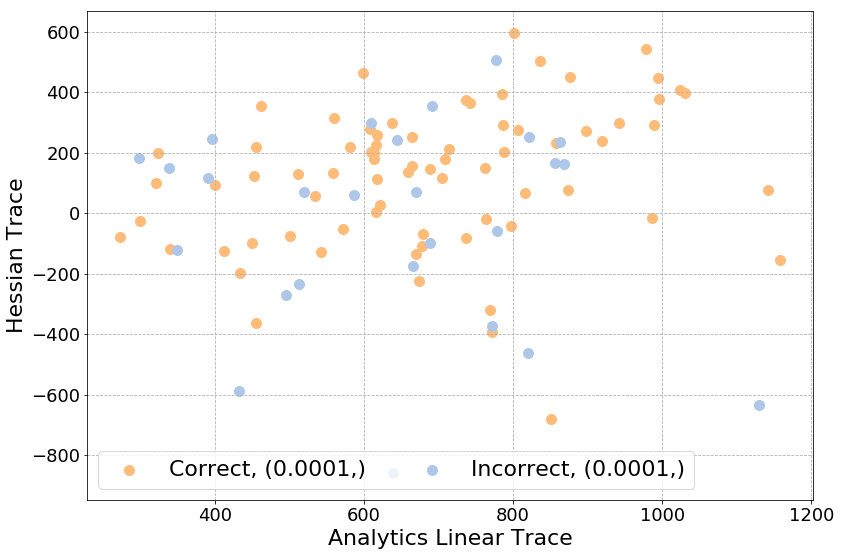

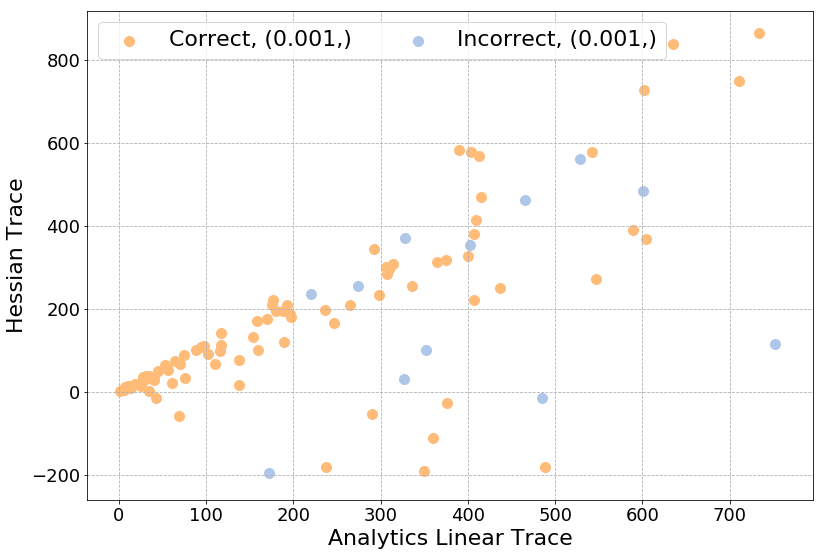

In [12]:

# Plot trace vs margins
X_axis_name = "Analytics Linear Trace"
Y_axis_name = "Hessian Trace"


plot_name = "Correct_Incorrect"
X_axis_bounds = None
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = ["learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True

data_func = margin_trace_correct_incorrect_plot(linear_loss_trace_filters, point_traces, use_correct_filter=use_correct_filter)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)

